In [13]:
# This is a simple Decision tree on time series data with Flight Delay predictions
# Using the package DecisionTreeClassifier from sklearn
# Loading all the packages
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
import math

from keras.callbacks import History as history


In [14]:
#reading flight delayed csv
dataset = pd.read_csv('sample_data/Delay_Flight_Airport_Visibility_Cleaned.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (36) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
dataset.head()

,X,Origin.City,Date,Destination.IATA,Origin.IATA,Weekday,DepTime,CRSDepTime,ArrTime,UniqueCarrier,CRSArrTime,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Origin.Airport,Origin.State,Origin.Latitude,Origin.Longitude,Destination.Airport,Destination.City,Destination.State,Destination.Latitude,Destination.Longitude,Max.Temp,Min.Temp,visibility,Date.1,CommuteTime,CRSCommuteTime
1,2,Albuquerque,2008-01-10,PHX,ABQ,Thursday,20:02,19:35,21:11,WN,20:50,160,N409WN,69,75,55,21,27,328,6,8,21,0,0,0,0,Albuquerque International,NM,35.040222,-106.609194,Phoenix Sky Harbor International,Phoenix,AZ,33.434167,-112.008056,2.4,-36.4,4,2008-01-10,69,75
2,3,Albuquerque,2008-01-04,HOU,ABQ,Friday,19:31,18:45,22:25,WN,21:40,1925,N522SW,174,175,100,45,46,759,2,12,2,0,0,0,43,Albuquerque International,NM,35.040222,-106.609194,William P X,Houston,TX,29.645419,-95.278889,2.4,-36.4,4,2008-01-04,174,175
3,5,Albuquerque,2008-01-31,STL,ABQ,Thursday,10:52,10:40,14:10,WN,13:55,2546,N323SW,198,195,123,15,12,934,5,10,0,0,3,0,12,Albuquerque International,NM,35.040222,-106.609194,Lambert-St Louis International,St Louis,MO,38.747687,-90.359990,2.4,-36.4,4,2008-01-31,198,195
4,6,Albuquerque,2008-01-02,LBB,ABQ,Wednesday,16:00,15:30,17:49,WN,17:25,555,N512SW,109,115,43,24,30,289,2,4,1,0,0,0,23,Albuquerque International,NM,35.040222,-106.609194,Lubbock International,Lubbock,TX,33.663639,-101.822778,2.4,-36.4,4,2008-01-02,109,115
5,7,Albuquerque,2008-01-29,DFW,ABQ,Tuesday,18:12,17:30,20:40,AA,20:15,636,N298AA,148,165,73,25,42,569,8,7,0,0,0,0,25,Albuquerque International,NM,35.040222,-106.609194,Dallas-Fort Worth International,Dallas-Fort Worth,TX,32.895951,-97.037200,2.4,-36.4,4,2008-01-29,148,165


In [15]:
def convertToFloat( data ):
  dataConverted = []

  for item in data:

    if type(item) == str:
      item = re.sub("−", "-", item)
    convertedVal = float(item)
    dataConverted.append(convertedVal)
  
  print(len(data))
  print(len(dataConverted))
  return dataConverted

In [16]:
dataset['Max.Temp'] = convertToFloat(dataset['Max.Temp'])
# max_temp = pd.DataFrame(max_temp)
# print(max_temp)
dataset['Min.Temp'] = convertToFloat(dataset['Min.Temp'])
dataset['Origin.Latitude'] = convertToFloat(dataset['Origin.Latitude'])
dataset['Origin.Longitude'] = convertToFloat(dataset['Origin.Longitude'])


dataset=dataset.dropna()

353453
353453
353453
353453
353453
353453
353453
353453


In [17]:


def getTime (time):
  timearr = []
  index = 0
  for item in time: 
    h, m = time.iloc[index].split(":")
    #\ timestring = datetime.time(int(hours), int(minutes))
    timearr.append(int(datetime.timedelta(hours=int(h or 0),minutes=int(m)).total_seconds()))

    # timearr.append(int(hours * 3600 + minutes * 60) )
    index += 1
  return timearr

  



In [18]:

# def getDateTime (dateInt, timeStr):
#   groupHour = 4
  
#   [hours, minutes] = timeStr.split(":")

#   group = math.floor(int(hours or 0) / groupHour)
#   return float(str(dateInt) + "." + str(group))


# def convertTime( date, arrTime ):
#   dataConverted = []
#   index = 0
  
#   for item in date:
#     # [hour, minute] = arrTime.iloc[index].split(":")
#     # time = hour.rjust(2, '0') + minute.rjust(2, '0') 
#     [year, month, day] = item.split("-")
#     # convertedVal = datetime.date(int(year), int(month), int(day))
#     convertedVal = getDateTime(int(month+day),arrTime.iloc[index])
#     dataConverted.append(convertedVal)
#     # print(convertedVal + "-" + time + "-" + arrTime.iloc[index])
    
#     index += 1
  
  
#   print(convertedVal)
#   return dataConverted

def getMonth (dateInt):
  dataConverted = []
  index = 0
  
  for item in dateInt:
    # [hour, minute] = arrTime.iloc[index].split(":")
    # time = hour.rjust(2, '0') + minute.rjust(2, '0') 
    [year, month, day] = item.split("-")
    getMonth = int(month)
    # convertedVal = converteddate.toordinal()
    # convertedVal = getDateTime(int(month+day),arrTime.iloc[index])
    dataConverted.append(getMonth)
    # print(convertedVal + "-" + time + "-" + arrTime.iloc[index])
    
    index += 1
  
  return dataConverted



In [19]:
def getIntWeekDay (weekDay):
  weekday = weekDay.lower()
  if weekday == "sunday":
    return 1
  elif weekday == "monday":
    return 2
  elif weekday == "tuesday":
    return 3
  elif weekday == "wednesday":
    return 4
  elif weekday == "thursday":
    return 5
  elif weekday == "friday":
    return 6
  else:
    return 7

dataset["intWeekDay"] = list(map(getIntWeekDay, dataset['Weekday']))

In [20]:
import numpy as np

def stringToNumeric(text):
  vocab=sorted(set(text))
  char_to_ind = {char:ind for ind,char in enumerate(vocab)}
  encoded_text = np.array([str(char_to_ind[c])for c in text])
  return int("".join(encoded_text))


# print(stringToNumeric("hemant"))
# print(stringToNumeric("tnameh"))

dataset["intUniqueCarrier"] = list(map(stringToNumeric, dataset['UniqueCarrier']))

In [21]:
dataset['Month'] = getMonth(dataset['Date'])
# dataset['CRSArrTime'] = getTime(dataset['CRSArrTime'])
# dataset['CRSDepTime'] = getTime(dataset['CRSDepTime'])
dataset['DateTimeOrdinal'] = getMonth(dataset['Date'])
dataset['CRSArrTime'] = getTime(dataset['CRSArrTime'])
dataset['DepTime'] = getTime(dataset['DepTime'])

dataset['CRSDepTime'] = getTime(dataset['CRSDepTime'])

In [22]:
dataset.head()


,X,Origin.City,Date,Destination.IATA,Origin.IATA,Weekday,DepTime,CRSDepTime,ArrTime,UniqueCarrier,CRSArrTime,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Origin.Airport,Origin.State,Origin.Latitude,Origin.Longitude,Destination.Airport,Destination.City,Destination.State,Destination.Latitude,Destination.Longitude,Max.Temp,Min.Temp,visibility,Date.1,CommuteTime,CRSCommuteTime,intWeekDay,intUniqueCarrier,Month,DateTimeOrdinal
1,2,Albuquerque,2008-01-10,PHX,ABQ,Thursday,72120,70500,21:11,WN,75000,160,N409WN,69,75,55,21,27,328,6,8,21,0,0,0,0,Albuquerque International,NM,35.040222,-106.609194,Phoenix Sky Harbor International,Phoenix,AZ,33.434167,-112.008056,2.4,-36.4,4,2008-01-10,69,75,5,10,1,1
2,3,Albuquerque,2008-01-04,HOU,ABQ,Friday,70260,67500,22:25,WN,78000,1925,N522SW,174,175,100,45,46,759,2,12,2,0,0,0,43,Albuquerque International,NM,35.040222,-106.609194,William P X,Houston,TX,29.645419,-95.278889,2.4,-36.4,4,2008-01-04,174,175,6,10,1,1
3,5,Albuquerque,2008-01-31,STL,ABQ,Thursday,39120,38400,14:10,WN,50100,2546,N323SW,198,195,123,15,12,934,5,10,0,0,3,0,12,Albuquerque International,NM,35.040222,-106.609194,Lambert-St Louis International,St Louis,MO,38.747687,-90.359990,2.4,-36.4,4,2008-01-31,198,195,5,10,1,1
4,6,Albuquerque,2008-01-02,LBB,ABQ,Wednesday,57600,55800,17:49,WN,62700,555,N512SW,109,115,43,24,30,289,2,4,1,0,0,0,23,Albuquerque International,NM,35.040222,-106.609194,Lubbock International,Lubbock,TX,33.663639,-101.822778,2.4,-36.4,4,2008-01-02,109,115,4,10,1,1
5,7,Albuquerque,2008-01-29,DFW,ABQ,Tuesday,65520,63000,20:40,AA,72900,636,N298AA,148,165,73,25,42,569,8,7,0,0,0,0,25,Albuquerque International,NM,35.040222,-106.609194,Dallas-Fort Worth International,Dallas-Fort Worth,TX,32.895951,-97.037200,2.4,-36.4,4,2008-01-29,148,165,3,0,1,1


In [23]:
#split dataset in features and target variable
# feature_cols = ['SecurityDelay', 'NASDelay', 'WeatherDelay','CarrierDelay','LateAircraftDelay']
# X = dataset[feature_cols] # Features
# feature_cols = ['DateTimeOrdinal','CRSElapsedTime','CRSArrTime','visibility','Min.Temp','AirTime','CRSDepTime','NASDelay']
feature_cols = ['Month','intWeekDay','CRSElapsedTime','CRSArrTime','visibility','Min.Temp','DepTime','AirTime','CRSDepTime']
# feature_cols = ['Month','intWeekDay','CRSElapsedTime','CRSArrTime','visibility','Min.Temp','AirTime','CRSDepTime','NASDelay']
X = dataset[feature_cols] # Features

In [24]:
dataset['status'] = np.where((dataset['ArrDelay'] < 45) , 'slightly delayed', 'extremely delayed')
y = dataset['status'] # Target variable

In [25]:
dataset.head()

,X,Origin.City,Date,Destination.IATA,Origin.IATA,Weekday,DepTime,CRSDepTime,ArrTime,UniqueCarrier,CRSArrTime,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Origin.Airport,Origin.State,Origin.Latitude,Origin.Longitude,Destination.Airport,Destination.City,Destination.State,Destination.Latitude,Destination.Longitude,Max.Temp,Min.Temp,visibility,Date.1,CommuteTime,CRSCommuteTime,intWeekDay,intUniqueCarrier,Month,DateTimeOrdinal,status
1,2,Albuquerque,2008-01-10,PHX,ABQ,Thursday,72120,70500,21:11,WN,75000,160,N409WN,69,75,55,21,27,328,6,8,21,0,0,0,0,Albuquerque International,NM,35.040222,-106.609194,Phoenix Sky Harbor International,Phoenix,AZ,33.434167,-112.008056,2.4,-36.4,4,2008-01-10,69,75,5,10,1,1,slightly delayed
2,3,Albuquerque,2008-01-04,HOU,ABQ,Friday,70260,67500,22:25,WN,78000,1925,N522SW,174,175,100,45,46,759,2,12,2,0,0,0,43,Albuquerque International,NM,35.040222,-106.609194,William P X,Houston,TX,29.645419,-95.278889,2.4,-36.4,4,2008-01-04,174,175,6,10,1,1,extremely delayed
3,5,Albuquerque,2008-01-31,STL,ABQ,Thursday,39120,38400,14:10,WN,50100,2546,N323SW,198,195,123,15,12,934,5,10,0,0,3,0,12,Albuquerque International,NM,35.040222,-106.609194,Lambert-St Louis International,St Louis,MO,38.747687,-90.359990,2.4,-36.4,4,2008-01-31,198,195,5,10,1,1,slightly delayed
4,6,Albuquerque,2008-01-02,LBB,ABQ,Wednesday,57600,55800,17:49,WN,62700,555,N512SW,109,115,43,24,30,289,2,4,1,0,0,0,23,Albuquerque International,NM,35.040222,-106.609194,Lubbock International,Lubbock,TX,33.663639,-101.822778,2.4,-36.4,4,2008-01-02,109,115,4,10,1,1,slightly delayed
5,7,Albuquerque,2008-01-29,DFW,ABQ,Tuesday,65520,63000,20:40,AA,72900,636,N298AA,148,165,73,25,42,569,8,7,0,0,0,0,25,Albuquerque International,NM,35.040222,-106.609194,Dallas-Fort Worth International,Dallas-Fort Worth,TX,32.895951,-97.037200,2.4,-36.4,4,2008-01-29,148,165,3,0,1,1,slightly delayed


In [26]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# training_set,test_set = train_test_split(X, y, test_size=0.3, random_state=1)



In [27]:
type(X_train)

pandas.core.frame.DataFrame

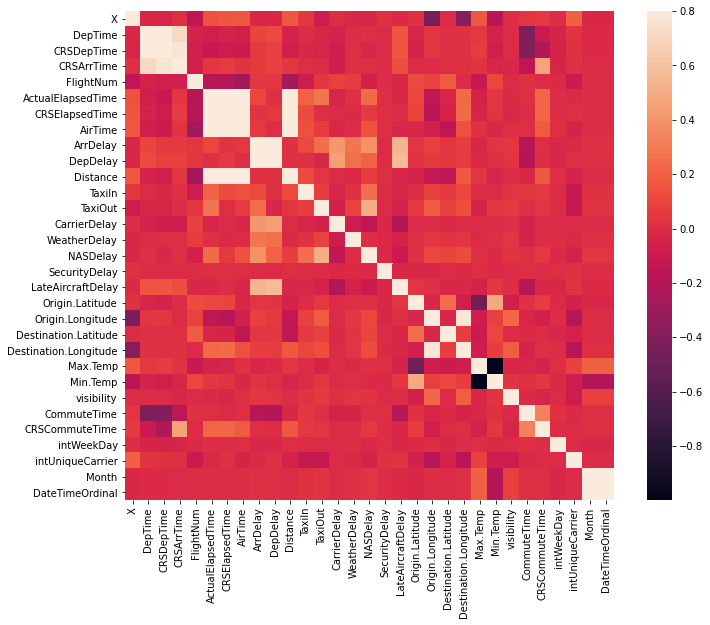

In [28]:
#correlation matrix
corr_mat = dataset.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);
plt.show()

In [29]:
print ("Rows           =",dataset.shape[0])
print ("Columns        =",dataset.shape[1])
print ("\nFeatures       =\n  ",dataset.columns.to_list())
print ("\nNull Values    =",dataset.isnull().sum().values.sum())
print ("\nunique Values  =\n",dataset.nunique())

Rows           = 353453
Columns        = 46

Features       =
   ['X', 'Origin.City', 'Date', 'Destination.IATA', 'Origin.IATA', 'Weekday', 'DepTime', 'CRSDepTime', 'ArrTime', 'UniqueCarrier', 'CRSArrTime', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Origin.Airport', 'Origin.State', 'Origin.Latitude', 'Origin.Longitude', 'Destination.Airport', 'Destination.City', 'Destination.State', 'Destination.Latitude', 'Destination.Longitude', 'Max.Temp', 'Min.Temp', 'visibility', 'Date.1', 'CommuteTime', 'CRSCommuteTime', 'intWeekDay', 'intUniqueCarrier', 'Month', 'DateTimeOrdinal', 'status']

Null Values    = 0

unique Values  =
 X                        353453
Origin.City                  18
Date                        366
Destination.IATA            239
Origin.IATA                  21
Weekday                       7
DepTime   

In [30]:
dataset.head()

,X,Origin.City,Date,Destination.IATA,Origin.IATA,Weekday,DepTime,CRSDepTime,ArrTime,UniqueCarrier,CRSArrTime,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Origin.Airport,Origin.State,Origin.Latitude,Origin.Longitude,Destination.Airport,Destination.City,Destination.State,Destination.Latitude,Destination.Longitude,Max.Temp,Min.Temp,visibility,Date.1,CommuteTime,CRSCommuteTime,intWeekDay,intUniqueCarrier,Month,DateTimeOrdinal,status
1,2,Albuquerque,2008-01-10,PHX,ABQ,Thursday,72120,70500,21:11,WN,75000,160,N409WN,69,75,55,21,27,328,6,8,21,0,0,0,0,Albuquerque International,NM,35.040222,-106.609194,Phoenix Sky Harbor International,Phoenix,AZ,33.434167,-112.008056,2.4,-36.4,4,2008-01-10,69,75,5,10,1,1,slightly delayed
2,3,Albuquerque,2008-01-04,HOU,ABQ,Friday,70260,67500,22:25,WN,78000,1925,N522SW,174,175,100,45,46,759,2,12,2,0,0,0,43,Albuquerque International,NM,35.040222,-106.609194,William P X,Houston,TX,29.645419,-95.278889,2.4,-36.4,4,2008-01-04,174,175,6,10,1,1,extremely delayed
3,5,Albuquerque,2008-01-31,STL,ABQ,Thursday,39120,38400,14:10,WN,50100,2546,N323SW,198,195,123,15,12,934,5,10,0,0,3,0,12,Albuquerque International,NM,35.040222,-106.609194,Lambert-St Louis International,St Louis,MO,38.747687,-90.359990,2.4,-36.4,4,2008-01-31,198,195,5,10,1,1,slightly delayed
4,6,Albuquerque,2008-01-02,LBB,ABQ,Wednesday,57600,55800,17:49,WN,62700,555,N512SW,109,115,43,24,30,289,2,4,1,0,0,0,23,Albuquerque International,NM,35.040222,-106.609194,Lubbock International,Lubbock,TX,33.663639,-101.822778,2.4,-36.4,4,2008-01-02,109,115,4,10,1,1,slightly delayed
5,7,Albuquerque,2008-01-29,DFW,ABQ,Tuesday,65520,63000,20:40,AA,72900,636,N298AA,148,165,73,25,42,569,8,7,0,0,0,0,25,Albuquerque International,NM,35.040222,-106.609194,Dallas-Fort Worth International,Dallas-Fort Worth,TX,32.895951,-97.037200,2.4,-36.4,4,2008-01-29,148,165,3,0,1,1,slightly delayed


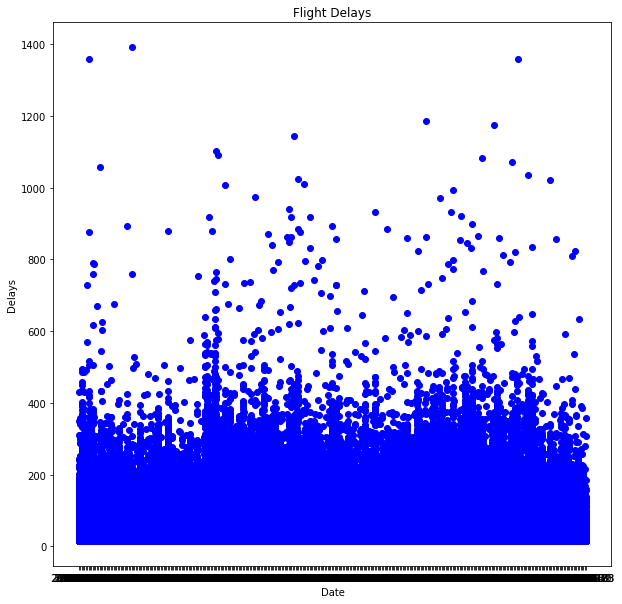

In [31]:

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))
dataset.index = dataset['Date']

# Add x-axis and y-axis
dataset['status'] 

ax.scatter(x = dataset['Date'], y = dataset['ArrDelay'],color='b')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Delays",
       title="Flight Delays")

plt.show()

In [32]:
dataset.head()

,X,Origin.City,Date,Destination.IATA,Origin.IATA,Weekday,DepTime,CRSDepTime,ArrTime,UniqueCarrier,CRSArrTime,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Origin.Airport,Origin.State,Origin.Latitude,Origin.Longitude,Destination.Airport,Destination.City,Destination.State,Destination.Latitude,Destination.Longitude,Max.Temp,Min.Temp,visibility,Date.1,CommuteTime,CRSCommuteTime,intWeekDay,intUniqueCarrier,Month,DateTimeOrdinal,status
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-10,2,Albuquerque,2008-01-10,PHX,ABQ,Thursday,72120,70500,21:11,WN,75000,160,N409WN,69,75,55,21,27,328,6,8,21,0,0,0,0,Albuquerque International,NM,35.040222,-106.609194,Phoenix Sky Harbor International,Phoenix,AZ,33.434167,-112.008056,2.4,-36.4,4,2008-01-10,69,75,5,10,1,1,slightly delayed
2008-01-04,3,Albuquerque,2008-01-04,HOU,ABQ,Friday,70260,67500,22:25,WN,78000,1925,N522SW,174,175,100,45,46,759,2,12,2,0,0,0,43,Albuquerque International,NM,35.040222,-106.609194,William P X,Houston,TX,29.645419,-95.278889,2.4,-36.4,4,2008-01-04,174,175,6,10,1,1,extremely delayed
2008-01-31,5,Albuquerque,2008-01-31,STL,ABQ,Thursday,39120,38400,14:10,WN,50100,2546,N323SW,198,195,123,15,12,934,5,10,0,0,3,0,12,Albuquerque International,NM,35.040222,-106.609194,Lambert-St Louis International,St Louis,MO,38.747687,-90.359990,2.4,-36.4,4,2008-01-31,198,195,5,10,1,1,slightly delayed
2008-01-02,6,Albuquerque,2008-01-02,LBB,ABQ,Wednesday,57600,55800,17:49,WN,62700,555,N512SW,109,115,43,24,30,289,2,4,1,0,0,0,23,Albuquerque International,NM,35.040222,-106.609194,Lubbock International,Lubbock,TX,33.663639,-101.822778,2.4,-36.4,4,2008-01-02,109,115,4,10,1,1,slightly delayed
2008-01-29,7,Albuquerque,2008-01-29,DFW,ABQ,Tuesday,65520,63000,20:40,AA,72900,636,N298AA,148,165,73,25,42,569,8,7,0,0,0,0,25,Albuquerque International,NM,35.040222,-106.609194,Dallas-Fort Worth International,Dallas-Fort Worth,TX,32.895951,-97.037200,2.4,-36.4,4,2008-01-29,148,165,3,0,1,1,slightly delayed


In [559]:
#converting dataset to float
dataset=dataset.X
dataset = dataset.astype('float32')

In [33]:

print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (247417, 9)
y_train shape =  (247417,)

x_test shape =  (106036, 9)
y_test shape =  (106036,)


In [34]:
from sklearn.preprocessing import MinMaxScaler #bununla, 0-1 arasına scale ettik
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(X)
train_scaled

array([[0.        , 0.66666667, 0.2027027 , ..., 0.83460737, 0.17142857,
        0.81329562],
       [0.        , 0.83333333, 0.54054054, ..., 0.81306463, 0.31428571,
        0.77793494],
       [0.        , 0.66666667, 0.60810811, ..., 0.4523975 , 0.38730159,
        0.43493635],
       ...,
       [0.72727273, 0.66666667, 0.54054054, ..., 0.39402363, 0.27936508,
        0.34299859],
       [0.72727273, 0.16666667, 0.4222973 , ..., 0.51633079, 0.19047619,
        0.50212164],
       [0.72727273, 1.        , 0.67905405, ..., 0.26337735, 0.41269841,
        0.23691655]])

In [487]:
# # from sklearn.preprocessing import MinMaxScaler #bununla, 0-1 arasına scale ettik
# # scaler = MinMaxScaler(feature_range = (0, 1))
# # train_scaled = scaler.fit_transform(X)
# # train_scaled

# # reshape input to be [samples, time steps, features]
# # X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

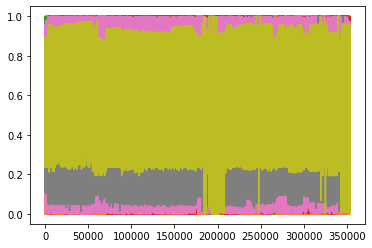

In [35]:
plt.plot(train_scaled)

In [36]:

X_train = []
y_train = []
timesteps = 50

for i in range(timesteps, 1250):
    X_train.append(train_scaled[i - timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)


In [37]:

X_test = []
y_test = []
timesteps = 50

for i in range(timesteps, 1250):
    X_test.append(train_scaled[i - timesteps:i, 0])
    y_test.append(train_scaled[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)


In [38]:
#import libraries and packages:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

#Initialize RNN:
regressor = Sequential()

#Adding the first RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation='tanh', return_sequences=True, input_shape= (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

#Adding the second RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation='tanh', return_sequences=True))
regressor.add(Dropout(0.2))

#Adding the third RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation='tanh', return_sequences=True))
regressor.add(Dropout(0.2))

#Adding the fourth RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

#Compile the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

print ('model compiled')

print (regressor.summary())


model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50, 50)            2600      
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50, 50)            5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50, 50)            5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 50)  

In [39]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test,y_test = np.array(X_test), np.array(y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

delayModel = regressor.fit(X_train, y_train, epochs=100)


Epoch 1/100
38/38 [==============================] - 5s 39ms/step - loss: 0.7067 - accuracy: 0.4893
Epoch 2/100
38/38 [==============================] - 1s 39ms/step - loss: 0.2842 - accuracy: 0.6002
Epoch 3/100
38/38 [==============================] - 1s 39ms/step - loss: 0.2140 - accuracy: 0.6232
Epoch 4/100
38/38 [==============================] - 2s 39ms/step - loss: 0.1489 - accuracy: 0.6448
Epoch 5/100
38/38 [==============================] - 1s 39ms/step - loss: 0.1254 - accuracy: 0.6451
Epoch 6/100
38/38 [==============================] - 2s 40ms/step - loss: 0.1128 - accuracy: 0.6963
Epoch 7/100
38/38 [==============================] - 1s 39ms/step - loss: 0.0793 - accuracy: 0.6896
Epoch 8/100
38/38 [==============================] - 1s 39ms/step - loss: 0.0712 - accuracy: 0.6892
Epoch 9/100
38/38 [==============================] - 1s 38ms/step - loss: 0.0677 - accuracy: 0.6684
Epoch 10/100
38/38 [==============================] - 1s 39ms/step - loss: 0.0546 - accuracy: 0.6825

In [40]:

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
X_test.shape
# X_test= scaler.fit_transform(X_test)
#converting dataset to float
X_test = X_test.astype('float32')
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

predicted_Flight_delays = regressor.predict(X_test)


In [41]:
accuracy = regressor.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

38/38 [==============================] - 1s 11ms/step - loss: 0.0016 - accuracy: 0.7258
Test set
  Loss: 0.002
  Accuracy: 0.726


In [42]:

mean_squared_error(y_test,predicted_Flight_delays)

0.0015636818760174742

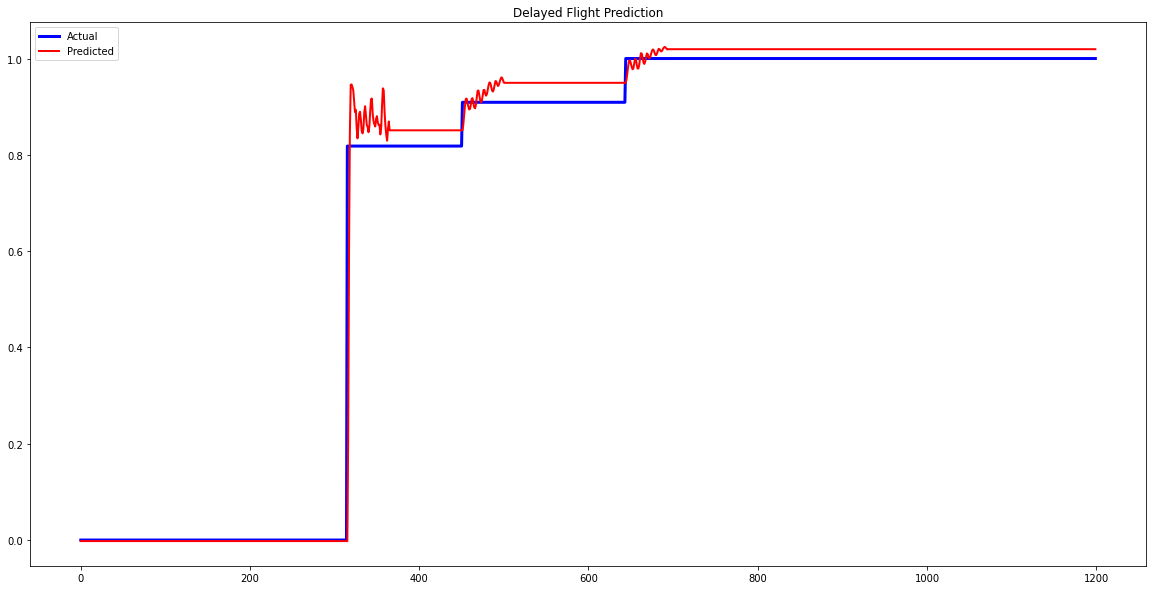

In [44]:
#predicted verses actual values
plt.figure(figsize=(20,10))
plt.plot(y_test , 'blue', linewidth=3)
plt.plot(predicted_Flight_delays[:,:1000],'r' , linewidth=2)
plt.legend(('Actual','Predicted'))
plt.title("Delayed Flight Prediction")
# plt.xlim((650,800))
plt.show()